## Cartpole dynamical system
 
The visualization of the phase space, and trajectory of a cartpole system.

In [161]:
%matplotlib inline

import scipy
import numpy as np
from IPython import display
import matplotlib.pyplot as plt

from cartpole_env import CartPoleEnv

In [162]:
def state_space(m=1, M=5, L=2, g=-10, d=1, s=1):
    """Calculates the linearized approximation of the cart-pendulum
    system dynamics at either the vertical-up position (s=1) or
    vertical-down position (s=-1).

    Returns two arrays, A, B which are the system and input matrices
    in the state-space system of differential equations:

        x_dot = Ax + Bu

    where x is the state vector, u is the control vector and x_dot
    is the time derivative (dx/dt).
    """
    A = np.array([
        [       0.,         1.,               0.,       0.],
        [       0,        -d/M,           -m*g/M,       0.],
        [       0.,         0.,               0.,       1.],
        [       0., -s*d/(M*L), -s*(m+M)*g/(M*L),       0.]
    ])

    B = np.array([
        [         0.],
        [       1./M],
        [         0.],
        [ s*1./(M*L)]
    ])

    return A, B

# Generate state space model matrices for linearized system
A, B = state_space()

A, B

(array([[ 0. ,  1. ,  0. ,  0. ],
        [ 0. , -0.2,  2. ,  0. ],
        [ 0. ,  0. ,  0. ,  1. ],
        [ 0. , -0.1,  6. ,  0. ]]),
 array([[0. ],
        [0.2],
        [0. ],
        [0.1]]))

In [163]:
# Calculate the controllability matrix
n_states = A.shape[0]
n_inputs = B.shape[1]
controllability_matrix = np.hstack([np.linalg.matrix_power(A, i) @ B for i in range(n_states)])

# Check the rank of the controllability matrix
rank_n = np.linalg.matrix_rank(controllability_matrix)

# Full rank means we have a controllable system
rank_n

4

In [164]:
# Essentially handpicking our pole/eigs positions, but LQR does this automatically.
# p = np.array([-1, -2, -5, -2.5])
# p = np.array([-1.5, -1.2, -1.3, -1.4])
# p = np.array([1, 0, 2, -1])
p = np.array([-1, -2.5, -2.3, -2.4])

# Some intuition, if you have very aggresive eigenvalues input you would need a 
# big motor to give these large control inputs. 

poles = scipy.signal.place_poles(A, B, p, method='YT', rtol=0.001, maxiter=30)
K = poles.gain_matrix

K.shape, A.shape, B.shape, (A - B @ K).shape

((1, 4), (4, 4), (4, 1), (4, 4))

In [165]:
# The gain matrix
K

array([[-13.8 , -32.07, 332.3 , 144.14]])

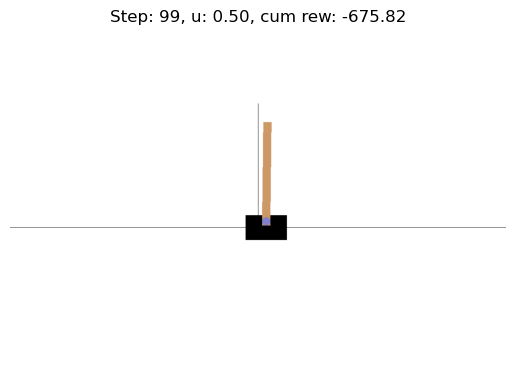

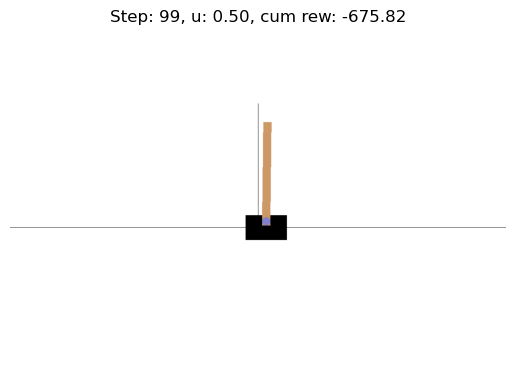

In [166]:
env = CartPoleEnv(initial_state_variance=0.01)
env.reset()

# Control vector
u = np.zeros(1)
cum_rew = 0.0

def show_state(env, step, cum_rew, u):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title(f"Step: {step}, u: {u[0]:.2f}, cum rew: {cum_rew:.2f}")
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

done = False
for step in range(100):
    # u = -Kx
    u[:] = -np.dot(K, env.state - env.goal_state)

    # Run simulation one time-step
    observation, reward, done, info = env.step(u)

    show_state(env, step, cum_rew, u)
    cum_rew += reward

    if done:
        break

env.close()

### Linear Quadratic Regulator (LQR)
automatically picks the eigenvalues to pick the optimal gain matrix K, balancing how fast you stabalize your state and howmuch energy you spend to do so.

In [168]:
B.shape, A.shape

((4, 1), (4, 4))

In [169]:

Q = np.eye(A.shape[0])
Q[2, 2] = 1
Q[3, 3] = 10

R = np.eye(B.shape[1]) * 0.0001
R

array([[0.0001]])

In [150]:
def lqr(A, B, Q, R):
    """Solve the continuous time LQR equation
    dx/dt = Ax + Bu
    cost = \int x^TQx + u^TRu dt
    """
     
    # Solve the continuous-time Riccati equation
    P = scipy.linalg.solve_continuous_are(A, B, Q, R)

    # Calculate the optimal control gain matrix K
    K = np.linalg.inv(R) @ B.T @ P

    result = np.linalg.eig(A - (B @ K))
    eigs = result.eigenvalues
    eigvecs = result.eigenvectors
    return K, eigs, eigvecs

# The gain matrix and eigenvalues
K, eigs, eigvecs = lqr(A, B, Q, R)
K, eigs, eigvecs

(array([[-100.        , -209.20537846, 1727.423981  ,  829.39075598]]),
 array([-37.53434517+0.j        ,  -1.40621076+0.90740538j,
         -1.40621076-0.90740538j,  -0.95123322+0.j        ]),
 array([[-0.02380413+0.j        , -0.4124278 -0.26613308j,
         -0.4124278 +0.26613308j, -0.72017149+0.j        ],
        [ 0.89347256+0.j        ,  0.821451  +0.j        ,
          0.821451  -0.j        ,  0.68505104+0.j        ],
        [-0.01194446+0.j        ,  0.0596212 -0.13646756j,
          0.0596212 +0.13646756j,  0.07956271+0.j        ],
        [ 0.44832742+0.j        ,  0.03999142+0.24600276j,
          0.03999142-0.24600276j, -0.07568269+0.j        ]]))

In [151]:
eigs.real

array([-37.53434517,  -1.40621076,  -1.40621076,  -0.95123322])

In [152]:
# Real part of the eigenvalues show which directions it is most aggressively stabilizing,
# apperantly, indices with highest values
eigvecs[:, 0].real

array([-0.02380413,  0.89347256, -0.01194446,  0.44832742])

In [153]:
# Steve brunton mentions as expected building the model is the hard part.

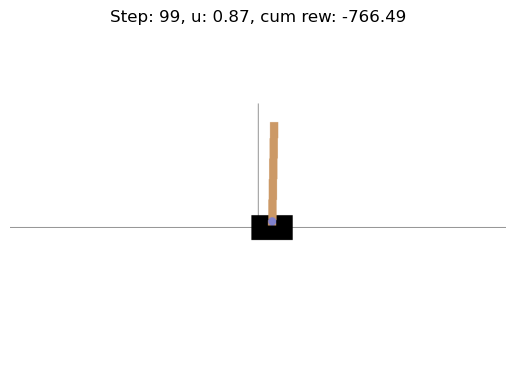

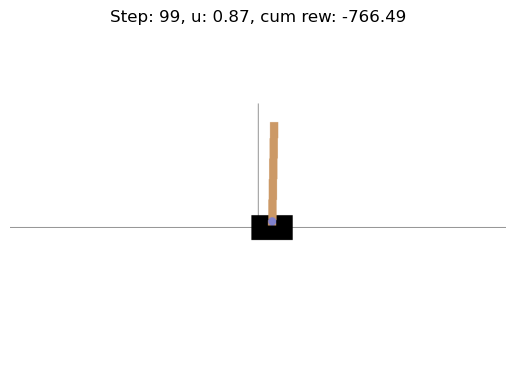

In [154]:
env = CartPoleEnv(initial_state_variance=0.00)
env.reset()

# Control vector
u = np.zeros(1)
cum_rew = 0.0

def show_state(env, step, cum_rew, u):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title(f"Step: {step}, u: {u[0]:.2f}, cum rew: {cum_rew:.2f}")
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

done = False
for step in range(100):
    # u = -Kx
    u[:] = -np.dot(K, env.state - env.goal_state)

    # Run simulation one time-step
    observation, reward, done, info = env.step(u)

    show_state(env, step, cum_rew, u)
    cum_rew += reward

    if done:
        break

env.close()

## Observability
Estimating the full state of the system

In [171]:
# Measuring just the position
C = np.array([1, 0, 0, 0])

n_states = A.shape[0]
observability_matrix = np.vstack([C @ np.linalg.matrix_power(A, i) for i in range(n_states)])
observability_matrix

array([[ 1.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  1.  ,  0.  ,  0.  ],
       [ 0.  , -0.2 ,  2.  ,  0.  ],
       [ 0.  ,  0.04, -0.4 ,  2.  ]])

In [172]:
np.linalg.det(observability_matrix), np.linalg.matrix_rank(observability_matrix)

(4.0, 4)

In [173]:
C = np.array([0, 0, 1, 0])
observability_matrix = np.vstack([C @ np.linalg.matrix_power(A, i) for i in range(n_states)])
observability_matrix

array([[ 0.  ,  0.  ,  1.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  1.  ],
       [ 0.  , -0.1 ,  6.  ,  0.  ],
       [ 0.  ,  0.02, -0.2 ,  6.  ]])

In [174]:
# Now location of the cart is not observable in the state space.
np.linalg.det(observability_matrix), np.linalg.matrix_rank(observability_matrix)

(0.0, 3)

In [179]:
Vd = 0.1 * np.eye(4)
Vn = np.array([[1]])

# BF = np

A.shape, C.shape, Vd.shape, Vn.shape

((4, 4), (4,), (4, 4), (1, 1))